# Imports

In [ ]:
!pip install -U keras==2.6.0 tensorflow-estimator==2.6.0 tf-models-official==2.6.0 

     |████████████████████████████████| 1.3 MB 4.2 MB/s 
     |████████████████████████████████| 462 kB 31.6 MB/s 
     |████████████████████████████████| 1.8 MB 36.0 MB/s 
     |████████████████████████████████| 596 kB 37.9 MB/s 
     |████████████████████████████████| 99 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |████████████████████████████████| 213 kB 48.7 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 4.9 MB 36.9 MB/s 
     |████████████████████████████████| 90 kB 8.6 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 47.6 MB 1.6 MB/s 
     |████████████████████████████████| 352 kB 48.8 MB/s 
     |████████████████████████████████| 458.3 MB 13 kB/s 
     |████████████████████████████████| 5.6 MB 41.6 MB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could

In [ ]:
!pip install texthero -U

In [ ]:
# Import necessary packages
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Data

For this Airbnb example, I used a csv file created using data from http://insideairbnb.com/get-the-data.html


*   Location: Austin, TX; San Francisco, CA; and Fort Lauderdale, FL

*   Listing id: Unique numberical number referencing a listing on Airbnb

*   Reviews: Guest review of the lising
*   Label: 0 (review does not allege misinformation) or 1 (review alleges that there is misinformation)







In [ ]:
# Mount Google Drive to download dataset
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/DS440/Data for project/Reviews_alleging_misinformation - Sheet1.csv')

In [ ]:
df.head()

We have two classes in the dataset

In [ ]:
df.Label.unique()

In [ ]:
df.dtypes

Let's check how equally distributed those classes are.

In [ ]:
classes = df.Label.unique()
counts = []

for i in classes:
  count = len(df[df.Label==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

NameError: ignored

Using the first dataset the class distribution is even. This is usually favorable in text classification, however, when using the dataset with 10% more reviews not alleging misinformation the BERT model score higher more consistently. 

To start modeling we still need to do a couple of things:

1.   Split data into train and test datasets
2.   Encode labels
3.   Tokenize text



## Cleaning Comments

In [ ]:
df['comments'][0]

In [ ]:
import texthero as hero
#DATA PREPROCESSING USING TEXTHERO PACKAGE
df['clean_reviews'] = hero.clean(df['comments'])

df['clean_review_length'] = df['clean_reviews'].apply(lambda x: len(x))


#create list of words
words_to_remove = ['(Website hidden by Airbnb)', '(Hidden by Airbnb)', 
'æ˜¯ä¸€ä¸ªéžå¸¸å‡ºè‰²çš„æˆ¿ä¸œ çœŸè¯š,ç»…å£«,å¹½é»˜ï½¡ä»–ä¼šå¸®åŠ©ä½ æè¡ŒæŽ,ç»™ä½ åšå¥½åƒçš„pancake,ä¹Ÿçƒ­å¿ƒåœ°æä¾›æ—…è¡Œå»ºè®®,å’Œä»–èŠå¤©éžå¸¸æœ‰è¶£ï½¡å…¬å¯“å°±å’Œç…§ç‰‡ä¸€æ¨¡ä¸€æ · å¤å¤ç¾Žå¼é£Ž æˆ‘éžå¸¸å–œæ¬¢~åœ°ç†ä½ç½®ä¹Ÿå¾ˆä¸é”™']

#thank and thanks, treatment and treatments, 
def remove_words(text):
    #text = text.replace('thanks','thank')
    #text = text.replace('treatments','treatment')
    text = " ".join([word for word in text.split() if word not in words_to_remove])
    return text


df['clean_reviews'] = df['clean_reviews'].apply(lambda x: remove_words(x))

# Lemmatizer
import nltk
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
  text= [wn.lemmatize(word) for word in text.split()]
  text = ' '.join(text)
  return text

df['clean_lem'] = df['clean_reviews'].apply(lambda x: lemmatizer(x))

df.head()

In [ ]:
df['comments'] = df['clean_reviews']
df.head()

## Train/test split

Finding the maximum length out of all the reviews to determine where to chunk.

In [ ]:
df['comments'][0]

In [ ]:
i = 0
for x in df['comments']:
  df['comments'][i] = x.split()
  i+=1  

df.head()

In [ ]:
df.shape

In [ ]:
y = 0
above = 0
length = 0
for x in df['comments']:
  y = len(x)
  if y > above:
    above = y

above

Max length is 1002 words without cleaning the reviews.


Max length is 484 when cleaning the reviews.

In [ ]:
df.iloc[1361]

In [ ]:
# Chunking the longer reviews so the do not get truncated later
i = 0
new_data = []
for c in df['comments']:
  if len(c) > 510:
    location = df['Location'][i]
    listing = df['listing_id'][i]
    label = df['Label'][i]
    new_data.append([location, listing, c[:510], label])
    new_data.append([location, listing, c[510:], label])
  else:
    location = df['Location'][i]
    listing = df['listing_id'][i]
    label = df['Label'][i]
    new_data.append([location, listing, c, label])
  i += 1 

new_data_frame = pd.DataFrame(new_data, columns=["Location", "listing_id", "comments", "Label"])

new_data_frame

In [ ]:
i = 0
for x in df['comments']:
  df['comments'][i] = ' '.join(x)
  i+=1  

df.head()

In [ ]:
df.iloc[1524]

In [ ]:
sample_size = int(len(df)) 
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.comments.values
y = sampleDf.Label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

## Label Encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
encoded_Y_train

In [ ]:
encoded_Y_train.shape

In [ ]:
encoder_fname = 'airbnb_classes.npy'
my_wd = '/content/drive/My Drive/DS440/Data for project/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [ ]:
 encoder = LabelEncoder()
 encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization

I am using the pretrained multilingual BERT model using functions from official.nlp.bert package.

## Bert Multi Cased

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Tokenize classification and seperation

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

In [ ]:
df.dtypes

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Comments shape', reviews.shape.as_list())

In [ ]:
reviews.shape

Checking the tokenized reviews

In [ ]:
x_train[0]

In [ ]:
tokenizedReview = tokenizer.tokenize(x_train[0])
for i in tokenizedReview:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Adding classification token

In [ ]:
reviews[8]

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

## Mask and input type

"The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding." (Adam0ling, 2021)

In [ ]:
input_word_ids

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

In [ ]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
input_type_ids

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into funcitons.



For our maximum sequence length, we used the chunk size + 2 for the separation and classification tokens.

In [ ]:
max_seq_length = 512

Functions themselves.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))
 
  input = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return input

And now we preprocess inputs.

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

# Model

## Initial training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Our model.

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up the training parameters.

In [ ]:
epochs = 6
batch_size = 5  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)


optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Set up a history to check our model performance afterwards.

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

#Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
y_pred = model.predict(X_test, verbose = False)
y_labels = np.argmax(y_pred,axis=1)

In [ ]:
i = 0
y_true = []
while i < len(dummy_y_test):
  y_true.append(int(dummy_y_test[i][1]))
  i += 1

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

accurate = accuracy_score(y_true, y_labels)
print("Testing Accuracy: {:.4f}".format(accurate))

precision = precision_score(y_true, y_labels)
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_true, y_labels)
print("Recall: {:.4f}".format(recall))

Training Accuracy: 0.9951
Testing Accuracy: 0.9182
Precision: 0.9062
Recall: 0.9560


In [ ]:
print(confusion_matrix(y_true, y_labels, labels = [0,1]))

[[129  24]
 [ 11 153]]


In [ ]:
print(classification_report(y_true, y_labels, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       153
           1       0.86      0.93      0.90       164

    accuracy                           0.89       317
   macro avg       0.89      0.89      0.89       317
weighted avg       0.89      0.89      0.89       317



#Downloading mislabeled reviews

In [ ]:
# Converting tokens back into words

new = X_test['input_word_ids'].numpy()

words = []
for t in new:
    words.append(tokenizer.convert_ids_to_tokens(t))


# Adding a space between each word
commented = [[' '.join(i)] for i in words]

# Add comments and labels into dataframes
d = pd.DataFrame(commented, columns = ['Comments'])

result = {'y-True': y_true, 'y_labels':y_labels}
df = pd.DataFrame(result)

# Combining the comments and labels into one dataframe
both = pd.concat([d, df], axis = 1, join = 'inner')
both

In [ ]:
# Downloading the files
from google.colab import files
(both.loc[~(both['y-True'] == both['y_labels'])]).to_csv('not-correct.csv') 
files.download('not-correct.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

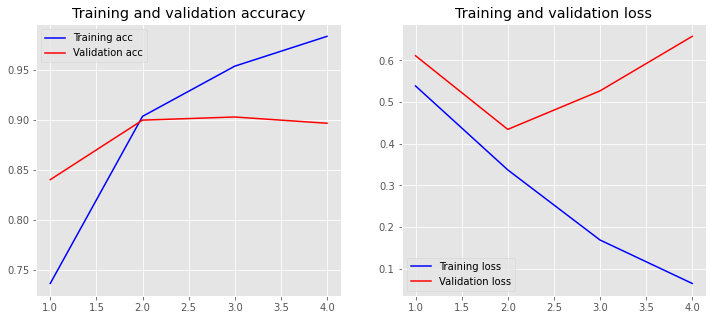

In [ ]:
plot_history(history)

Acknowledgements \\
The official link regarding the dataset with resources about how it was generated is [here](http://%20http//help.sentiment140.com/for-students/) \\
The official paper detailing the approach is [here](http://bhttp//cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

Citation: 

Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

Adam0ling (2021). MODIFIED_BERT. https://github.com/adam0ling/twitter_sentiment/blob/main/4_MODIFIED_BERT.ipynb